# Initialize and Train CGCNN

##### Automatically search for an NVIDIA GPU and use it. If not, then use CPU

In [1]:
import torch


if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

Using GPU


##### Load all of our preprocessed and split data from our cache

In [2]:
import pickle


# Label to use for this model in the plots
model_name = 'CGCNN-delta'

with open('../preprocessing/sdt/gasdb/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)

with open('../preprocessing/splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

docs_train = splits['docs_train']
docs_val = splits['docs_val']
sdts_train, sdts_val = splits['sdts_train'], splits['sdts_val']
targets_train, targets_val = splits['targets_train'], splits['targets_val']

# Where we put the intermediate results for this notebook
prefix = 'gasdb_pooled/'

##### Split train into train portion and error portion

In [3]:
err_start_ind = int(.9 * len(sdts_train))

sdts_err = sdts_train[err_start_ind:]
sdts_train = sdts_train[:err_start_ind]

targets_err_true = targets_train[err_start_ind:]
targets_train = targets_train[:err_start_ind]

##### Initialize the CGCNN `net` class

In [4]:
from torch.optim import Adam
# import skorch.callbacks.base
from skorch import callbacks  # needs skorch >= 0.4  
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from cgcnn.model import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


# Callback to checkpoint parameters every time there is a new best for validation loss
cp = callbacks.Checkpoint(monitor='valid_loss_best', fn_prefix=prefix+'valid_best_')

# Callback to load the checkpoint with the best validation loss at the end of training
class train_end_load_best_valid_loss(callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params(prefix+'valid_best_params.pt')
load_best_valid_loss = train_end_load_best_valid_loss()

# Callback to set the learning rate dynamically
LR_schedule = callbacks.lr_scheduler.LRScheduler('MultiStepLR', milestones=[100], gamma=0.1)

net = NeuralNetRegressor(
    CrystalGraphConvNet,
    module__orig_atom_fea_len=orig_atom_fea_len,
    module__nbr_fea_len=nbr_fea_len,
    batch_size=214,
    module__classification=False,
    lr=0.0056,
    max_epochs=150,
    module__atom_fea_len=46,
    module__h_fea_len=83,
    module__n_conv=8,
    module__n_h=4,
    optimizer=Adam,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn=collate_pool,
    iterator_train__shuffle=True,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn=collate_pool,
    iterator_valid__shuffle=False,
    device=device,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    callbacks=[cp, load_best_valid_loss, LR_schedule]
)

##### Training the CGCNN

In [5]:
net.initialize()
net.fit(sdts_train, targets_train)

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, h_fea_len, n_conv, n_h, nbr_fea_len, orig_atom_fea_len.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1        0.5866        0.5896     +  37.9416
      2        0.4016        0.3888     +  37.2240
      3        0.3651        0.3570     +  37.4369
      4        0.3101        0.3261     +  37.4653
      5        0.2981        0.3322        37.9713
      6        0.3139        0.3380        36.9064
      7        0.2996        0.2964     +  37.4617
      8        0.3023        0.3015        37.3099
      9        0.2948        0.2910     +  36.9754
     10        0.2722        0.3095        37.5138
     11        0.2759        0.2701     +  37.9992
     12        0.2772        0.2865        38.0263
     13        0.2614        0.2926        37.9358
     14        0.2719        0.2579     +  33.6708
  

    148        0.0952        0.1885     +  37.6021
    149        0.0944        0.1894        34.9437
    150        0.0940        0.1885     +  33.2197


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=CrystalGraphConvNet(
    (embedding): Linear(in_features=98, out_features=46, bias=True)
    (convs): ModuleList(
      (0): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(beta=1, threshold=20)
      )
      (1): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(

In [ ]:
# Restart training in case first round was cut off
net.partial_fit(sdts_train, targets_train)

##### ...or load whatever is cached

In [ ]:
net.initialize()
net.load_params(f_history=prefix+'valid_best_history.json',
                f_optimizer=prefix+'valid_best_optimizer.pt', 
                f_params=prefix+'valid_best_params.pt')

# Second CGCNN to Predict Error on Held Out Data

In [9]:
# Use CGCNN-1 to predict targets for sdts_err
# Find errors (difference) with targets_err_true, and define this difference to be targets_err
# Then: Train CGCNN on data (sdts_err, targets_err)

In [8]:
# Imports
import numpy as np

In [9]:
# Use CGCNN-1 to predict targets for sdts_err
targets_err_pred = net.predict(sdts_err).reshape(-1)

In [10]:
# Find errors (difference) with targets_err_true, and define this difference to be targets_err
targets_err = np.abs(targets_err_pred.flatten() - targets_err_true.flatten()).reshape(-1,1)

In [11]:
# Callback to checkpoint parameters every time there is a new best for error-set loss
cp = callbacks.Checkpoint(monitor='valid_loss_best', fn_prefix='err_best_')

# Callback to load the checkpoint with the best error-set loss at the end of training
class train_end_load_best_err_loss(callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('err_best_params.pt')
load_best_err_loss = train_end_load_best_err_loss()

# Callback to set the learning rate dynamically
LR_schedule = callbacks.lr_scheduler.LRScheduler('MultiStepLR', milestones=[100], gamma=0.1)

net_err = NeuralNetRegressor(
    CrystalGraphConvNet,
    module__orig_atom_fea_len=orig_atom_fea_len,
    module__nbr_fea_len=nbr_fea_len,
    batch_size=214,
    module__classification=False,
    lr=0.0056,
    max_epochs=150,
    module__atom_fea_len=46,
    module__h_fea_len=83,
    module__n_conv=8,
    module__n_h=4,
    optimizer=Adam,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn=collate_pool,
    iterator_train__shuffle=True,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn=collate_pool,
    iterator_valid__shuffle=False,
    device=device,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    callbacks=[cp, load_best_err_loss, LR_schedule]
)

In [12]:
# Train CGCNN on data (sdts_err, targets_err)
net_err.initialize()
net_err.fit(sdts_err, targets_err)

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, h_fea_len, n_conv, n_h, nbr_fea_len, orig_atom_fea_len.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.5794        0.1969     +  3.5805
      2        0.1577        0.1628     +  3.5466
      3        0.1726        0.1449     +  3.8490
      4        0.1487        0.1453        4.1554
      5        0.1656        0.1440     +  4.0940
      6        0.1270        0.1420     +  4.2631
      7        0.1406        0.1372     +  4.2575
      8        0.1302        0.1458        4.1667
      9        0.1428        0.1367     +  4.1724
     10        0.1548        0.1364     +  4.1775
     11        0.1492        0.1382        4.1866
     12        0.1333        0.1424        4.1104
     13        0.1333        0.1413        4.1485
     14        0.1643        0.1419        4.1038
     15        0.1

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=CrystalGraphConvNet(
    (embedding): Linear(in_features=98, out_features=46, bias=True)
    (convs): ModuleList(
      (0): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(beta=1, threshold=20)
      )
      (1): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(

In [ ]:
# To load what is cached
net_err.initialize()
net_err.load_params(f_history='err_best_history.json',
                f_optimizer= 'err_best_optimizer.pt', 
                f_params='err_best_params.pt')

# Assess Performance: CGCNN-delta
## All adsorbates
This latest chunk of data came from multiple adsorbates. To start simple, let's just plot everything within a single pool.

In [16]:
# Imports

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

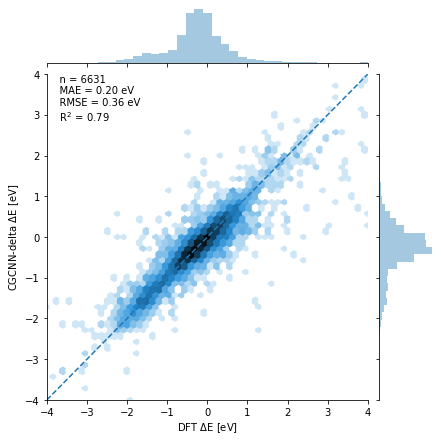

In [17]:
# Plotting results (original output space)

# Predict
targets_pred = net.predict(sdts_val)

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_val.reshape(-1),
                     targets_pred.reshape(-1),
                     kind='hex',
                     bins='log',
                     extent=lims*2)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_val, targets_pred))
r2 = r2_score(targets_val, targets_pred)

# Report
text = ('    n = %i\n'
        '    MAE = %.2f eV\n'
        '    RMSE = %.2f eV\n'
        '    R$^2$ = %.2f'
        % (len(targets_val), mae, rmse, r2))
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top')

In [18]:
# Predict errors on sdts_val (validation set)
targets_pred_err = net_err.predict(sdts_val).reshape(-1)

In [20]:
# Computing calibration

import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


residuals = targets_pred.flatten() - targets_val.flatten()
stdevs = targets_pred_err

def calculate_density(percentile):
    num_within_quantile = 0
    for stdev, resid in zip(stdevs, residuals):
        norm = stats.norm(loc=0, scale=stdev)
        lower_bound = norm.ppf(0.5-percentile/2)
        upper_bound = norm.ppf(0.5+percentile/2)
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1
    density = num_within_quantile / len(residuals)
    return density

predicted_pi = np.linspace(0, 1, 20)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

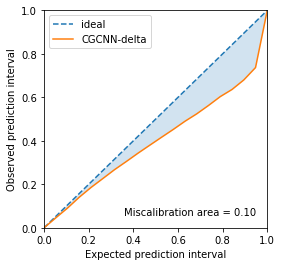

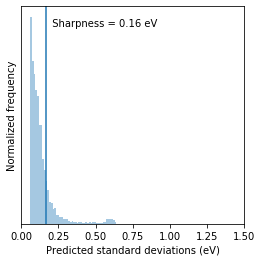

In [21]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon


# Plot settings
figsize = (4, 4)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected prediction interval')
_ = ax_ideal.set_ylabel('Observed prediction interval')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
miscalibration_area = polygon.area

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.2f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right')

# Plot sharpness curve
xlim = [0., 1.5]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviations (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV' % sharpness
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  ' % sharpness
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align)

In [22]:
miscalibration_area

0.10069133019549315